In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import pandas_datareader as web
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style("white")
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# 1. Get dataset from api website

In [3]:
"""Get the data from pandas datareader"""
def get_fred_dataset(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: xs - the date time values
                ys - the numeric values of the dataset
    """
    symbol = symbol 
    reader = web.fred.FredReader(symbol, start=pd.to_datetime(date_time))
    dataset = reader.read()
    #get numeric values from the pandas dataframe
    xs = dataset.index
    ys = dataset[symbol]
    return xs,ys

## Overview of dataset
[Fred](https://fred.stlouisfed.org/), short for Federal Reserve Economic Data, FRED is an online database consisting of hundreds of thousands of economic data time series from scores of national, international, public, and private sources.

In this problem, we will use 4 datasets: 

*   BRENT crude oil price: (DCOILBRENTEU) 
*   Heating Oil Prices: New York Harbor (DHOILNYH)
*   CBOE Crude Oil ETF Volatility Index (OVXCLS)
*   Conventional Gasoline Prices: New York Harbor, Regular (DGASNYH) 

In [4]:
# Get the DCOILBRENTEU dataset with data starting from 1-1-1880
xs,ys = get_fred_dataset('DCOILBRENTEU', '1880-01-01')

In [5]:
# Check missing values in the dataset
missing_values = ys.isnull().sum()
print(f"Missing values in the dataset: {missing_values}")

Missing values in the dataset: 266


In [6]:
# Visualize the dataset with matplotlib for time series
def plot_time_series(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    plt.plot(xs, ys)
    plt.title(f"{symbol} dataset from {date_time}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

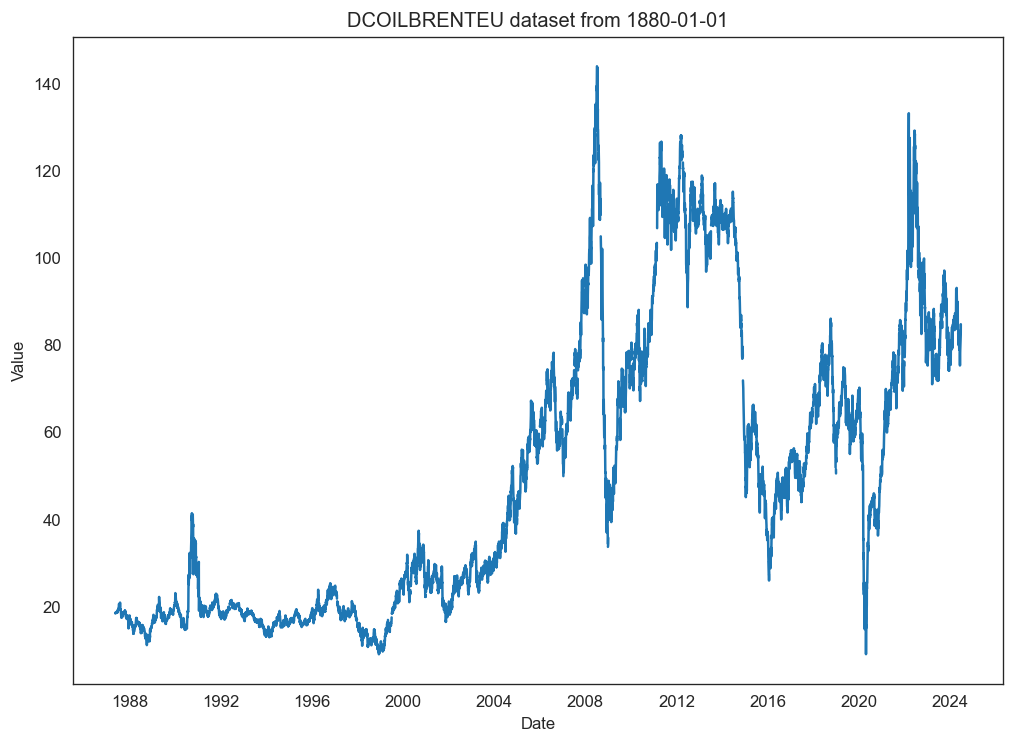

In [7]:
# Visualize the DCOILBRENTEU dataset
plot_time_series('DCOILBRENTEU', '1880-01-01')

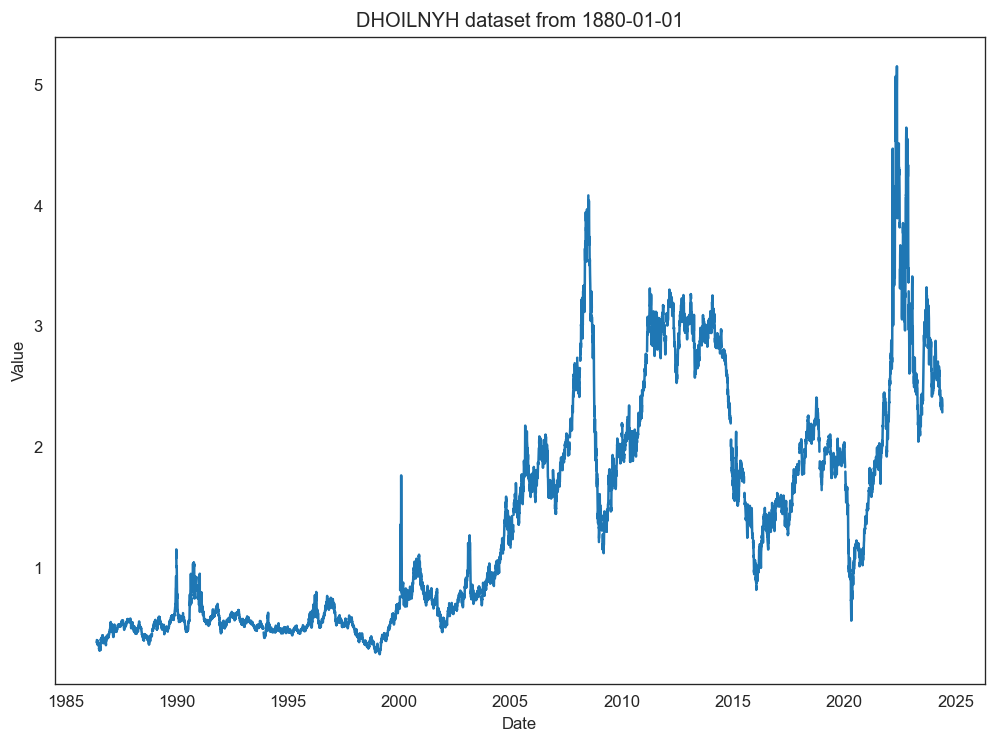

In [8]:
# Visualize the DHOILNYH dataset
plot_time_series('DHOILNYH', '1880-01-01')

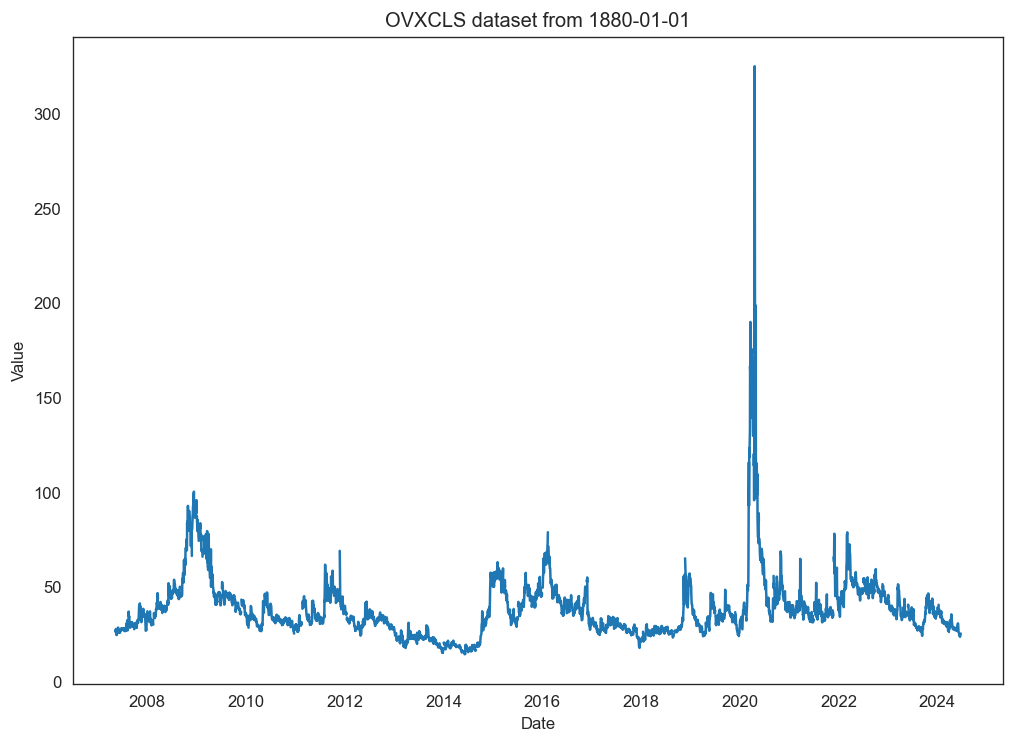

In [9]:
# Visualize the OVXCLS dataset
plot_time_series('OVXCLS', '1880-01-01')

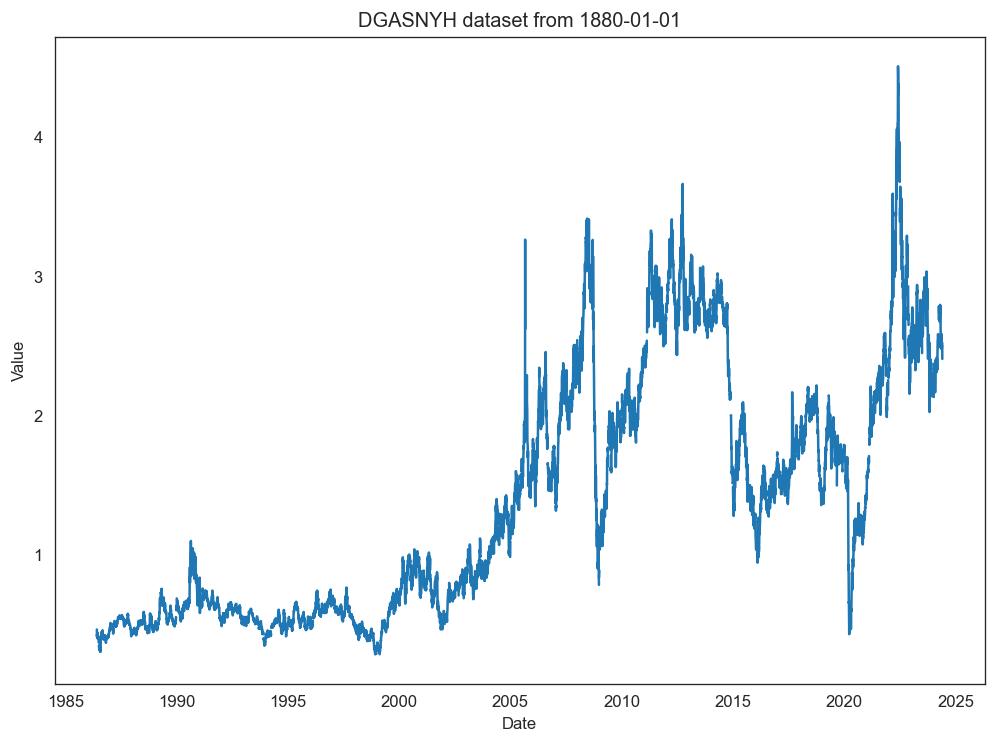

In [10]:
# Visualize the DGASNYH dataset
plot_time_series('DGASNYH', '1880-01-01')

# 2. Pre processing data

In [11]:
# Calcilate the linear inpute for the missing value between two points
import numpy as np


def linear_impute(y_start, y_end, npoints):
    """
    Input: y_start - the start value
               y_end - the end value
               npoints - the number of points to generate
    Output: the imputed values"""
    m = (y_end - y_start) / (npoints)
    c = y_start
    values = [m*x + c for x in range(1, npoints)]
    return values

# Linear impute the missing values in the dataset
def basic_imputation(ys):
    ys_imputed = np.copy(ys)
    b = np.isnan(ys_imputed)
    nan_positions = np.argwhere(b)
    segments = []
    for i in range(nan_positions.shape[0]):
        start = nan_positions[i]
        end = start
        while np.isnan(ys_imputed[end]) and end < ys.shape[0]:
            end = end + 1
        segments.append((start,end))
    for (start,end) in segments:
        y_start = ys_imputed[start-1]
        y_end = ys_imputed[end]
        linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
        # Ensure linear is a 1-dimensional array
        linear = np.array(linear).flatten()

        # Ensure the slice of ys_imputed matches the shape of linear
        assert len(ys_imputed[int(start):int(end)]) == len(linear)

        ys_imputed[int(start):int(end)] = linear
    return ys_imputed

In [12]:
# Visualize the DCOILBRENTEU dataset with the imputed values
def plot_imputed_time_series(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    ys_imputed = basic_imputation(ys)
    plt.plot(xs, ys_imputed)
    plt.title(f"{symbol} dataset from {date_time} after imputation")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

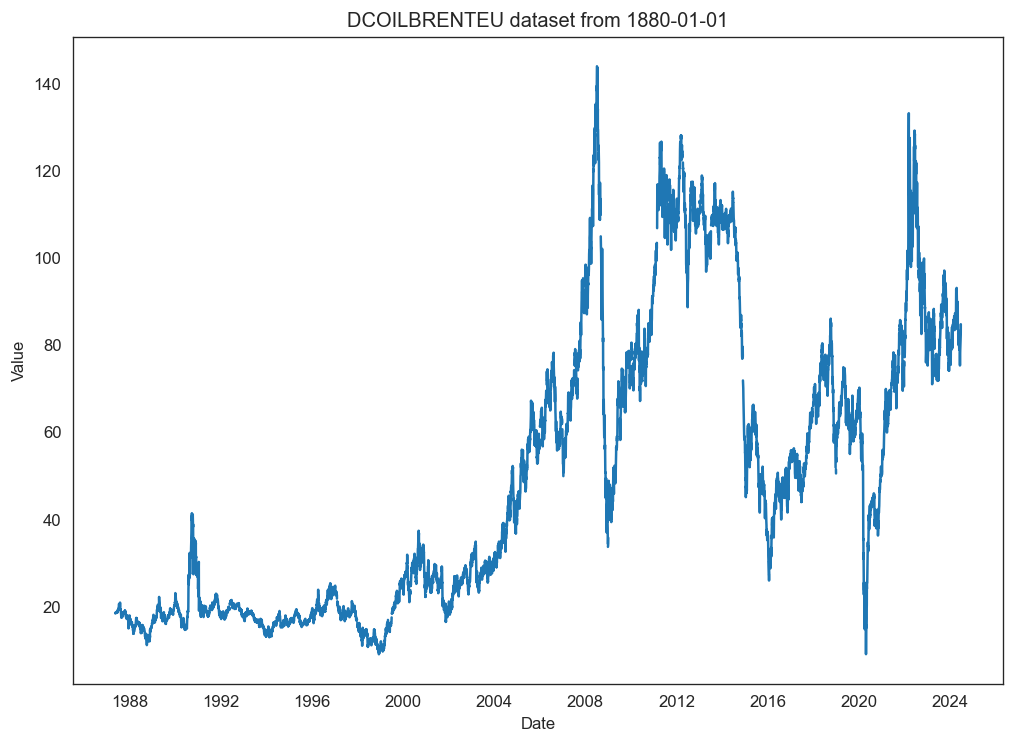

In [13]:
plot_time_series('DCOILBRENTEU', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

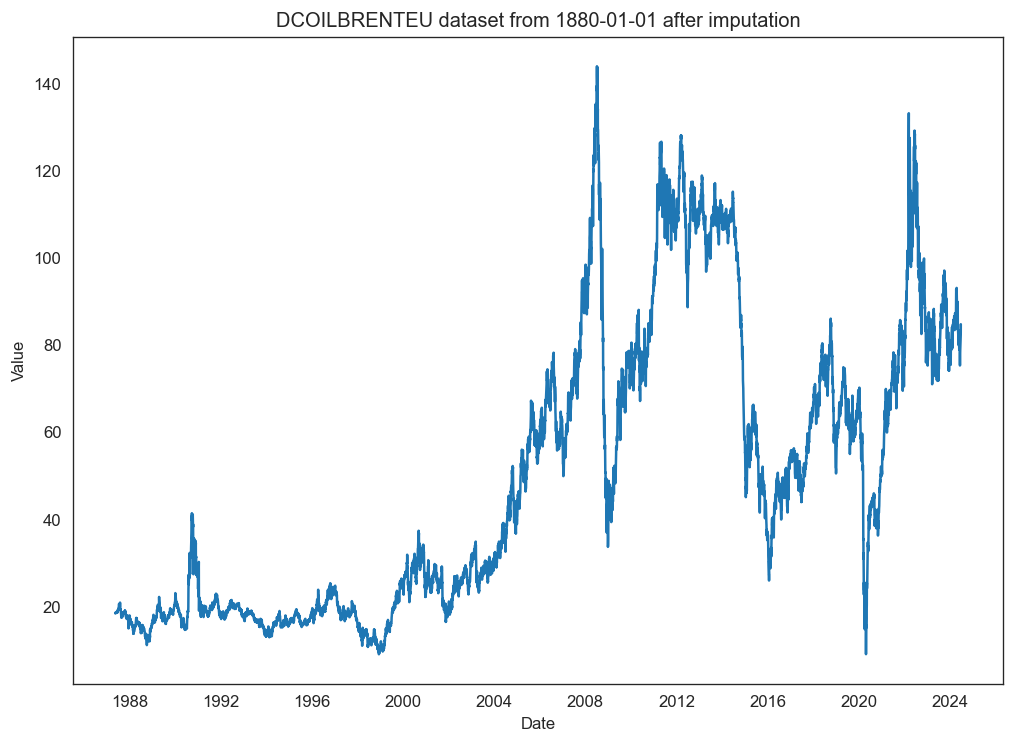

In [14]:
plot_imputed_time_series('DCOILBRENTEU', '1880-01-01')

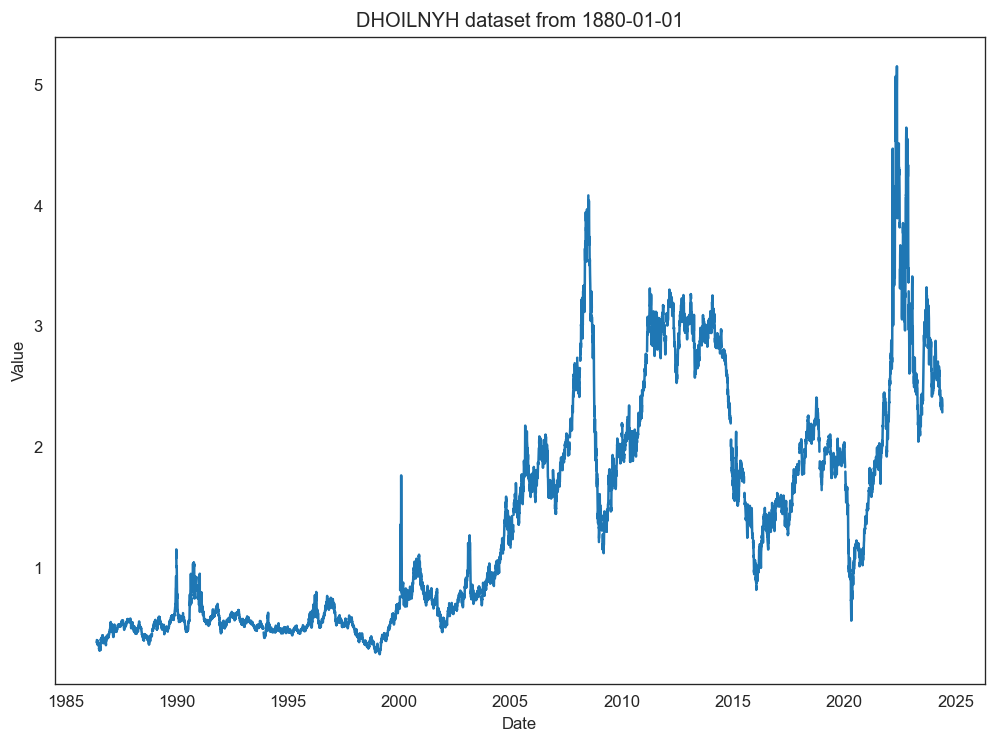

In [15]:
plot_time_series('DHOILNYH', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

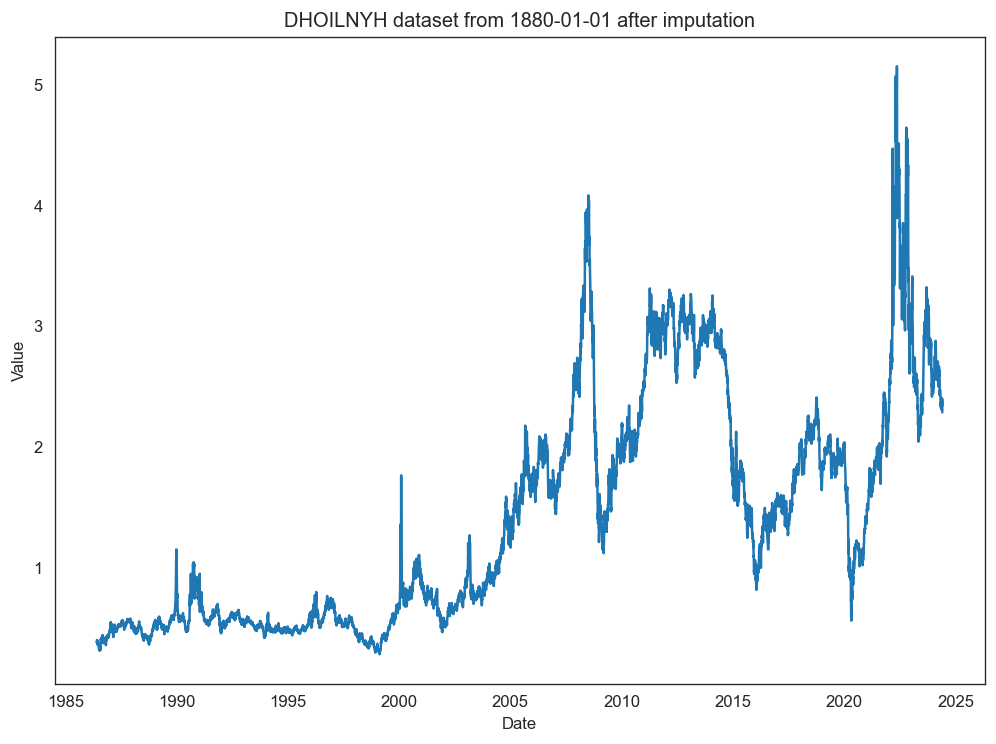

In [16]:
plot_imputed_time_series('DHOILNYH', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

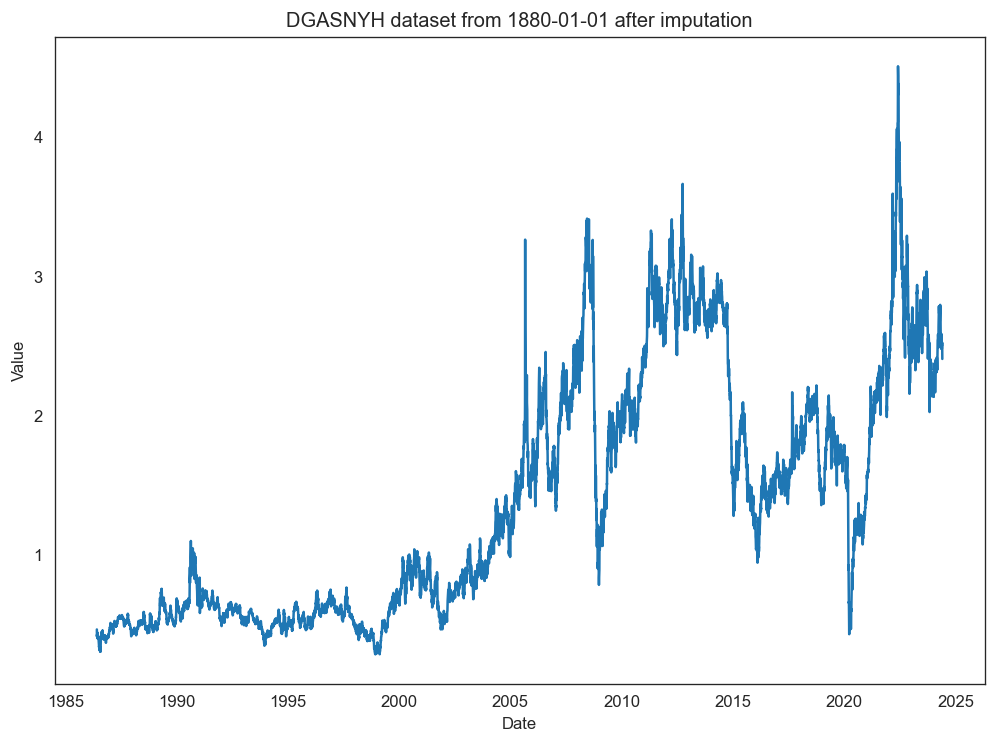

In [17]:
plot_imputed_time_series('DGASNYH', '1880-01-01')

## Seasonal and Trend decomposition using Loess (STL)

In [18]:
# Plot seasonal decomposition of the DCOILBRENTEU dataset
def plot_seasonal_decomposition(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    ys_imputed = basic_imputation(ys)
    result = seasonal_decompose(ys_imputed, model='additive', period=365)
    result.plot()
    plt.show()

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

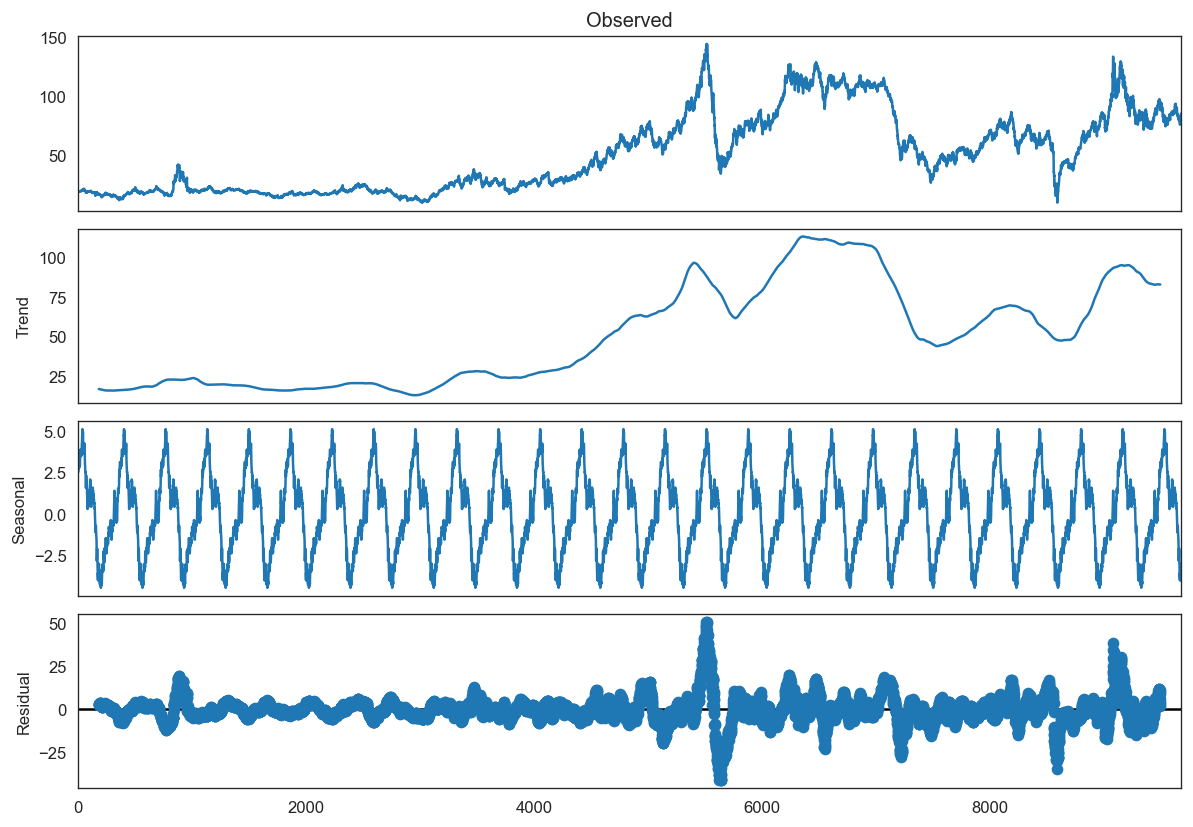

In [19]:
plot_seasonal_decomposition('DCOILBRENTEU', '1880-01-01')

In [20]:
def get_residual_com(symbol, y,index):
    y_df = pd.DataFrame({symbol: y}, index=index)
    y_decom = seasonal_decompose(y_df, model='additive')
    y_res= np.copy(y_decom.resid) 
    #padding missing "nan" datapoints with 1 at the beginning and end of residual sequence y_res
    y_res[0:2]=1
    y_res[y_res.shape[0]-2:y_res.shape[0]]=1
    return y_res

In [31]:
def plot_residuals(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    ys_imputed = basic_imputation(ys)
    y_res = get_residual_com(symbol,ys_imputed,xs)
    plt.plot(xs, y_res)
    plt.title(f"{symbol} dataset from {date_time} after get residual")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

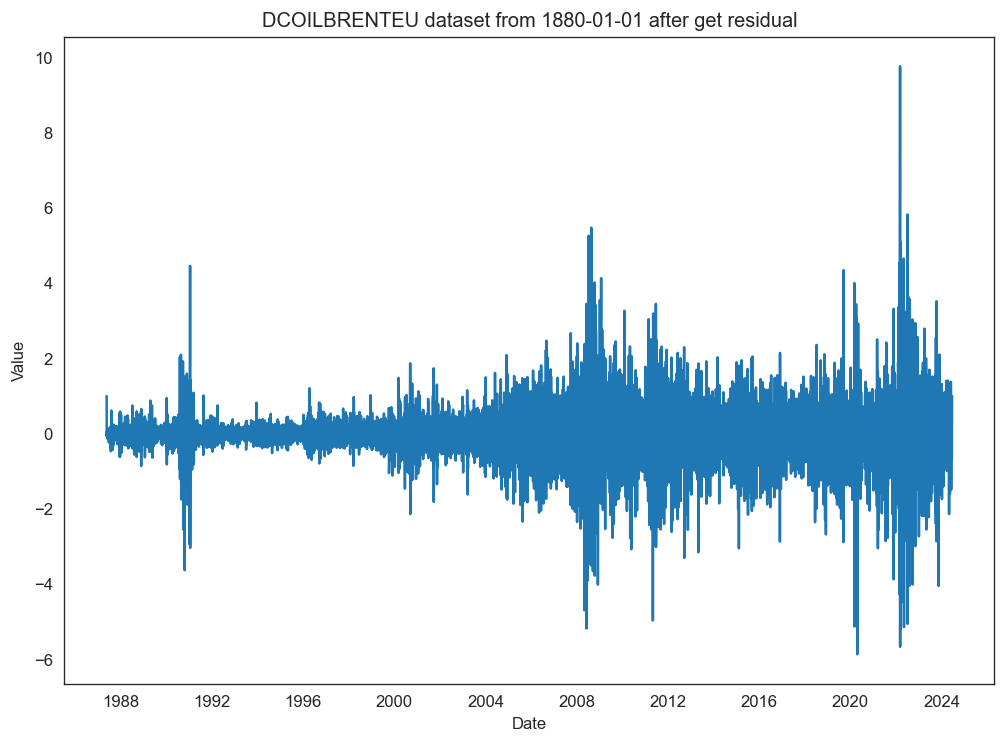

In [32]:
plot_residuals('DCOILBRENTEU', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

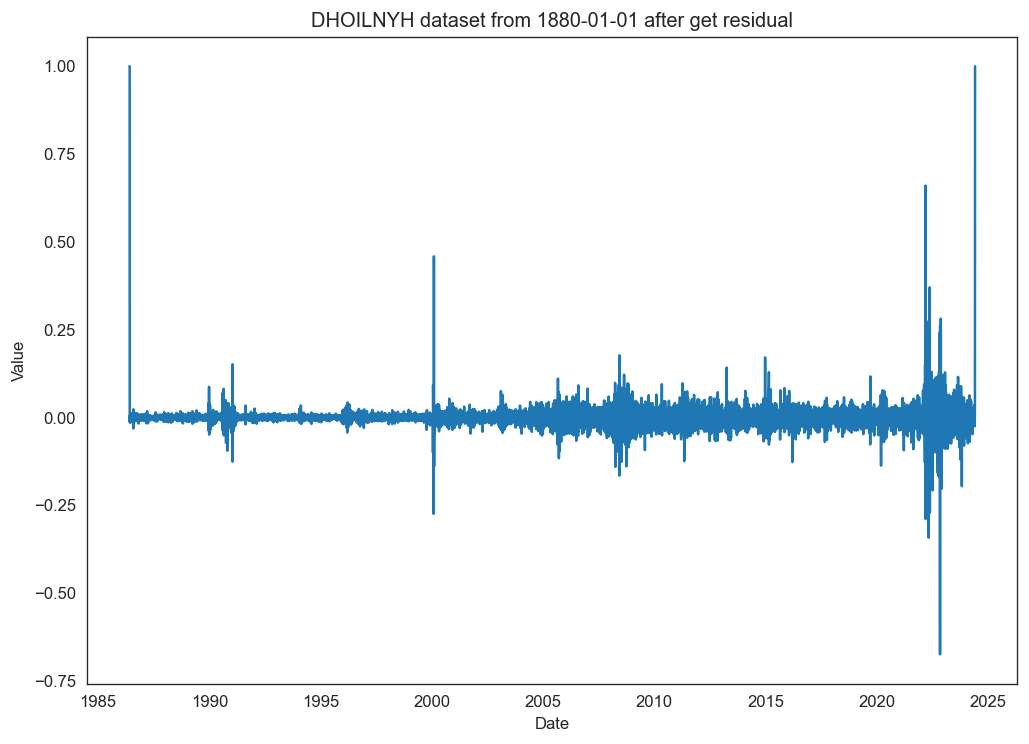

In [33]:
plot_residuals('DHOILNYH', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

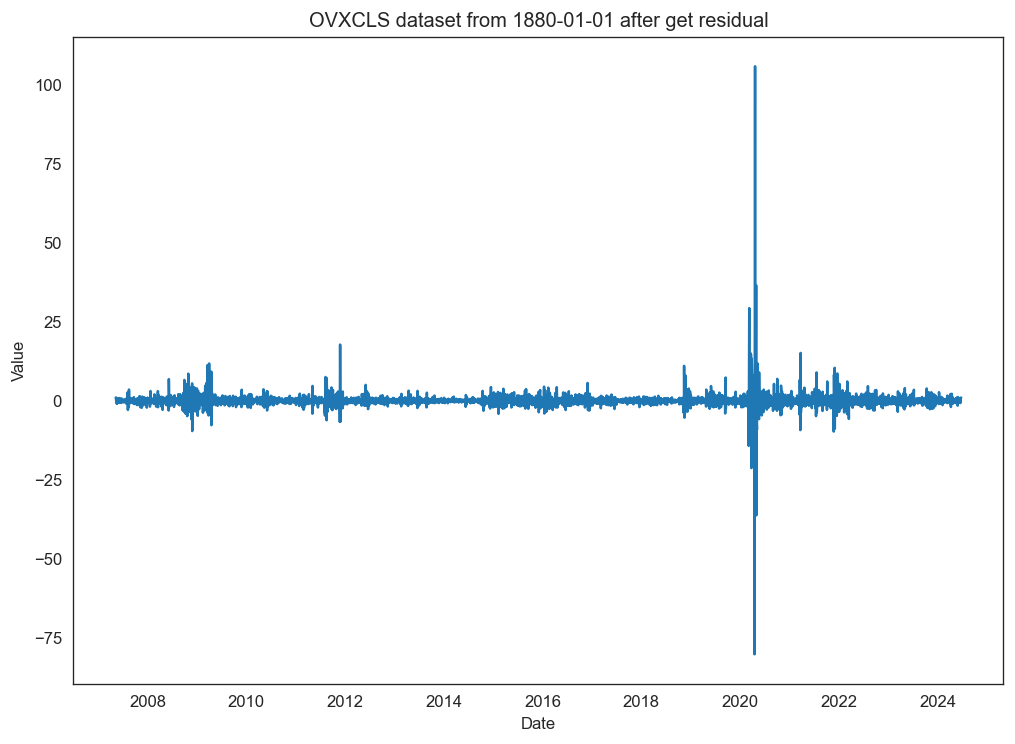

In [34]:
plot_residuals('OVXCLS', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

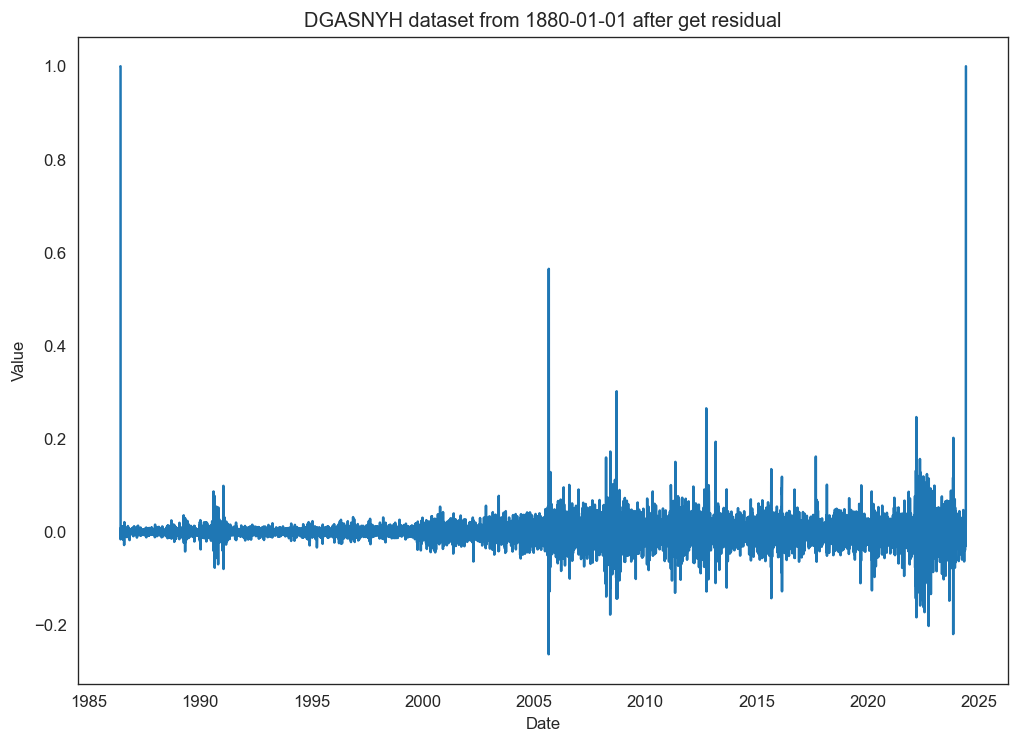

In [35]:
plot_residuals('DGASNYH', '1880-01-01')

# The spectral residual method

In [36]:
EPS = 1e-8
score_window = 100
mag_window = 3
look_ahead=5
extend_num=5

In [37]:
def sliding_window(dataset,window_size,normalization=None):
    """
    Sliding window transformation with optional per-window normalization

    Parameters
    ----------
    dataset : 1d array, dims = (N,)
        input 1d dataset to transform
    window_size : int
        size of sliding window
    normalization : func
        normalization to apply to each window

    Returns
    -------
    windows : 2d array, dims = (N-window_size,window_size)
    """

    assert(window_size >= 1)
    N_windows = dataset.shape[0] - window_size #8349
    windows = np.empty((N_windows,window_size)) # zero matrix 8349x100
    windows[:] = np.nan # nan matrix 8349x100
    for i in range(N_windows):
        arr = dataset[i:i+window_size] # (100,)
        if normalization is None:
          windows[i,:] = arr
        else:
            windows[i,:] = normalization(arr)
    return windows

In [38]:
def average_filter(values, n=3): #moving average
    """
    Calculate the sliding window average for the give time series.
    Mathematically, res[i] = sum_{j=i-t+1}^{i} values[j] / t, where t = min(n, i+1)
    :param values: list.
        a list of float numbers
    :param n: int, default 3.
        window size.
    :return res: list.
        a list of value after the average_filter process. 
    """

    if n >= len(values):
        n = len(values)

    res = np.cumsum(values, dtype=float)
    res[n:] = res[n:] - res[:-n]
    res[n:] = res[n:] / n

    for i in range(1, n):
        res[i] /= (i + 1)

    return res

- Fourier Transform: The method begins by applying the Fast Fourier Transform (FFT) to the input time series. This transforms the time series from the time domain to the frequency domain, allowing us to analyze the series in terms of its frequency components.
- Magnitude Spectrum: It calculates the magnitude spectrum of the transformed series. This step is crucial because the spectral residual method is based on the assumption that the magnitude spectrum contains the information about the periodicity of the time series, while the phase spectrum contains the more random components.
- Log Spectrum and Spectral Residual: By taking the logarithm of the magnitude spectrum, smoothing it (using an average filter), and then subtracting this smoothed spectrum from the original log spectrum, the method computes the spectral residual. This process effectively isolates the unexpected, non-periodic components of the time series, which are often indicative of anomalies.
- Inverse Fourier Transform: Finally, it applies the inverse FFT to the spectral residual, transforming it back into the time domain. The resulting time series highlights the anomalies.

In [39]:
def spectral_residual_transform(values):
    """
    This method transform a time series into spectral residual series
    :param values: list.
        a list of float values.
    :return: mag: list.
        a list of float values as the spectral residual values
    """

    trans = np.fft.fft(values)
    mag = np.sqrt(trans.real ** 2 + trans.imag ** 2)
    eps_index = np.where(mag <= EPS)[0]
    mag[eps_index] = EPS

    mag_log = np.log(mag)
    mag_log[eps_index] = 0

    spectral = np.exp(mag_log - average_filter(mag_log, n=mag_window))

    trans.real = trans.real * spectral / mag
    trans.imag = trans.imag * spectral / mag
    trans.real[eps_index] = 0
    trans.imag[eps_index] = 0

    wave_r = np.fft.ifft(trans)
    mag = np.sqrt(wave_r.real ** 2 + wave_r.imag ** 2)
    return mag

In [40]:
# Visualize the spectral residual transform of the DCOILBRENTEU dataset
def plot_spectral_residual_transform(symbol, date_time):
    """
    input: symbol - the symbol of the dataset
              date_time - the date to start the dataset
    output: None
    """
    xs,ys = get_fred_dataset(symbol, date_time)
    ys_imputed = basic_imputation(ys)
    y_res = get_residual_com(symbol,ys_imputed,xs)
    mag = spectral_residual_transform(y_res)
    plt.plot(xs, mag)
    plt.title(f"{symbol} dataset from {date_time} after spectral residual transform")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.show()

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

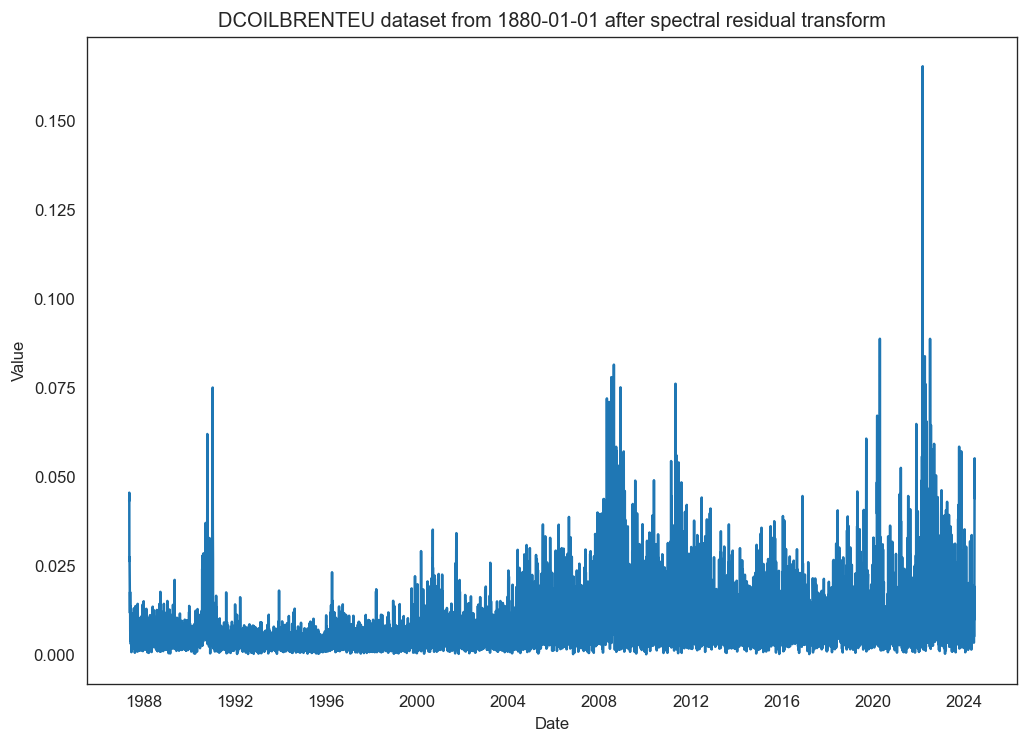

In [41]:
plot_spectral_residual_transform('DCOILBRENTEU', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

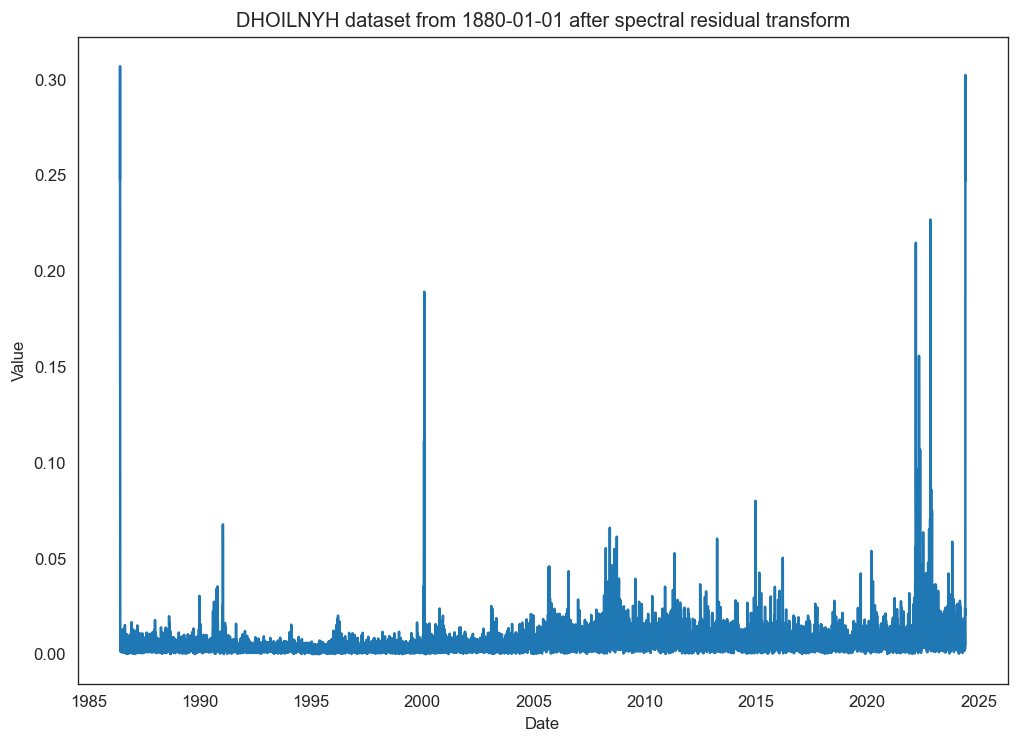

In [55]:
plot_spectral_residual_transform('DHOILNYH', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

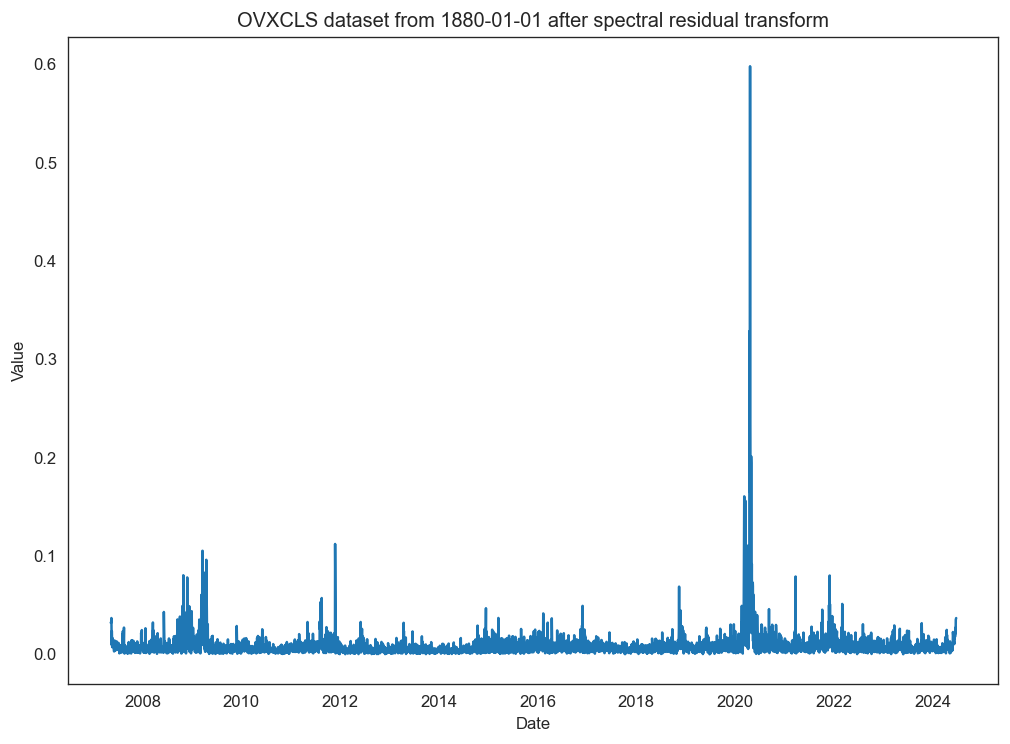

In [56]:
plot_spectral_residual_transform('OVXCLS', '1880-01-01')

/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  linear = linear_impute(y_start=y_start,y_end=y_end,npoints=int((end+1)-start))
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  assert len(ys_imputed[int(start):int(end)]) == len(linear)
/var/folders/7g/b6bnf9xj6hsdfj6hqx3tgqr00000gn/T/ipykernel_60253/1362924279.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

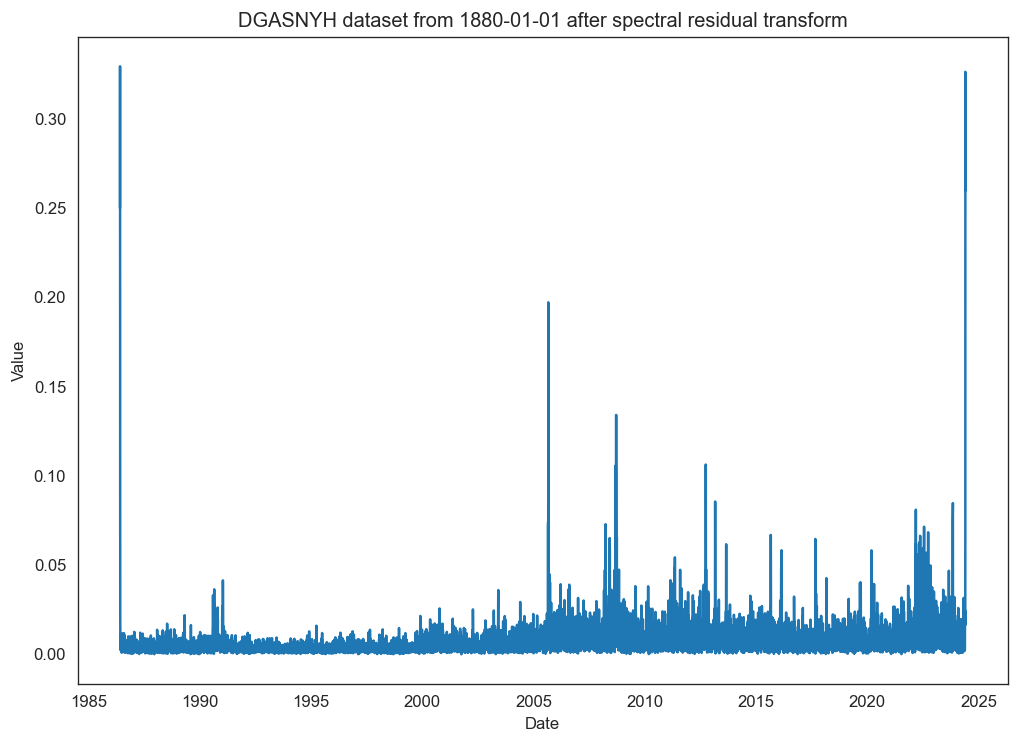

In [58]:
plot_spectral_residual_transform('DGASNYH', '1880-01-01')

In [42]:
def predict_next(values):
    """
    Predicts the next value by sum up the slope of the last value with previous values.
    Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
    where g(x_i,x_j) = (x_i - x_j) / (i - j), n=m=5??
    :param values: list.
        a list of float numbers.
    :return : float.
        the predicted next value.
    """

    if len(values) <= 1:
        raise ValueError(f'data should contain at least 2 numbers')

    v_last = values[-1]
    n = len(values) 
    
    slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

    return values[1] + sum(slopes) #? values[0] + sum(slopes) or just use values[1:5]

- Preprocessing with Extension: Before applying the spectral residual transform, your code extends the series (extend_series function). This can help in making predictions about future values and ensuring that the spectral residual method has a complete view of the time series, including its most recent trends.
- Normalization and Scoring: After obtaining the spectral residual, your code calculates a score (generate_spectral_score function) by normalizing the absolute difference between the original magnitude and its average. This score quantifies the level of anomaly at each point in the series, making it easier to identify and rank anomalies.
- Flexibility and Customization: The method allows for customization through parameters like score_window and mag_window, which control the smoothing of the magnitude spectrum and the scoring process. This flexibility lets you fine-tune the anomaly detection process to suit specific characteristics of your time series data.

In [43]:
def extend_series(values, extend_num=5, look_ahead=5):

    if look_ahead < 1:
        raise ValueError('look_ahead must be at least 1')

    extension = [predict_next(values[-look_ahead - 2:-1])] * extend_num
    return values + extension

In [44]:
def generate_spectral_score(series):
    extended_series = extend_series(series) #len 4005
    mag = spectral_residual_transform(extended_series)[:len(series)]
    ave_mag = average_filter(mag, n=score_window)
    ave_mag[np.where(ave_mag <= EPS)] = EPS

    return abs(mag - ave_mag) / ave_mag